In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# import

In [2]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.9-py3-none-any.whl size=184112 sha256=b70ba00de7717e1ee06d81eaf42282cdb6b27dddf72f7fd3517a12b0ef35a38d
  Stored in directory: /root/.cache/pip/wheels/1b/9c/b8/9759d7cc64a1e01bb9872ade80cb7db445ccf506e083325106
Successfully built pyod


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import *

from pyod.models.abod import ABOD
from sklearn.ensemble import IsolationForest

import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.backend import clear_session

import pickle
import numpy as np
import matplotlib.pyplot as plt


# Data Load

In [101]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/Data/train_data.csv')
df_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/Data/test_data.csv')

In [102]:
def tyep_to_hp(type_no):
  if type_no == 1:
    return 20
  elif type_no == 2:
    return 10
  elif type_no == 3:
    return 50
  else:
    return 30

In [103]:
df_train = df_train.drop(axis=1, columns=['out_pressure'])
df_train['type'] = df_train['type'].apply(tyep_to_hp)
df_train = df_train[(df_train['motor_vibe'] < 5) & (df_train['air_inflow'] < 3.5) & (df_train['motor_current'] < 45) & (df_train['air_end_temp'] > 35) & (df_train['motor_temp'] > 53) ]

In [104]:
df_data = df_data.drop(axis=1, columns=['out_pressure'])
df_data['type'] = df_data['type'].apply(tyep_to_hp)
#df_data = df_data[(df_data['motor_vibe'] < 5) & (df_data['air_inflow'] < 3.5) & (df_data['motor_current'] < 45) & (df_data['air_end_temp'] > 35) & (df_data['motor_temp'] > 53) ]

In [9]:
df_data

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,2.51,53.28,32.54,2662.0,69.58,3.48,30
1,2.66,55.24,34.45,2819.0,71.32,3.57,30
2,1.72,42.74,22.23,1819.0,60.21,3.01,30
3,2.20,49.15,28.50,2332.0,65.91,3.30,30
4,2.06,47.28,26.67,2182.0,64.24,3.21,30
...,...,...,...,...,...,...,...
7384,2.12,48.08,27.45,2246.0,64.96,3.25,30
7385,1.48,39.63,19.19,1570.0,57.44,2.87,30
7386,1.56,40.61,20.15,1649.0,58.32,2.92,30
7387,1.59,40.99,20.52,1679.0,58.66,2.93,30


# Model Load

In [10]:
clear_session()

n_inputs = df_data.shape[1]

# configure
input_data = Input(shape=(n_inputs,))

# layers
encoded = Dense(n_inputs//2, activation='relu')(input_data)
batnorm = BatchNormalization()(encoded)
dropout = Dropout(0.2)(batnorm)
encoded = Dense(n_inputs//4, activation='relu')(dropout)
batnorm = BatchNormalization()(encoded)
dropout = Dropout(0.2)(batnorm)

n_bottneck = 200
bottneck = Dense(n_bottneck, activation='relu')(dropout)

decoded = Dense(n_inputs//4, activation='relu')(bottneck)
batnorm = BatchNormalization()(decoded)
dropout = Dropout(0.2)(batnorm)
decoded = Dense(n_inputs//2, activation='relu')(dropout)
batnorm = BatchNormalization()(decoded)
dropout = Dropout(0.2)(batnorm)
decoded = Dense(n_inputs, activation='relu')(dropout)

# Models
autoencoder = Model(input_data, decoded) # autoencoder

encoder = Model(input_data, encoded) # encoder

In [11]:
autoencoder.load_weights('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/autoencoder.h5')

In [105]:
clear_session()

def model(n_inputs):
  # configure
  input_data = Input(shape=(n_inputs,))

  # layers
  encoded = Dense(n_inputs//2, activation='relu')(input_data)
  batnorm = BatchNormalization()(encoded)
  dropout = Dropout(0.2)(batnorm)
  encoded = Dense(n_inputs//4, activation='relu')(dropout)
  batnorm = BatchNormalization()(encoded)
  dropout = Dropout(0.2)(batnorm)

  n_bottneck = 200
  bottneck = Dense(n_bottneck, activation='relu')(dropout)

  decoded = Dense(n_inputs//4, activation='relu')(bottneck)
  batnorm = BatchNormalization()(decoded)
  dropout = Dropout(0.2)(batnorm)
  decoded = Dense(n_inputs//2, activation='relu')(dropout)
  batnorm = BatchNormalization()(decoded)
  dropout = Dropout(0.2)(batnorm)
  decoded = Dense(n_inputs, activation='relu')(dropout)

  # Models
  autoencoder = Model(input_data, decoded) # autoencoder

  encoder = Model(input_data, encoded) # encoder
  return autoencoder

#Predict

## 1st try

In [12]:
scaler = MinMaxScaler()
scaler.fit_transform(df_train)
test_df = scaler.transform(df_data)

In [13]:
reconstructions = autoencoder.predict(test_df)
loss = tf.keras.losses.mae(reconstructions, test_df)

def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  pred = tf.math.less(loss, threshold)
  pred = np.where(pred,0,1)
  return pred

231/231 [==============================] - 1s 995us/step


In [14]:
threshold = np.mean(loss) + np.std(loss)
print("Threshold: ", threshold)

Threshold:  0.38235400119714436


In [36]:
tmp = []

for ls in np.array(loss):
  if ls < 0.35:
    tmp.append(ls)


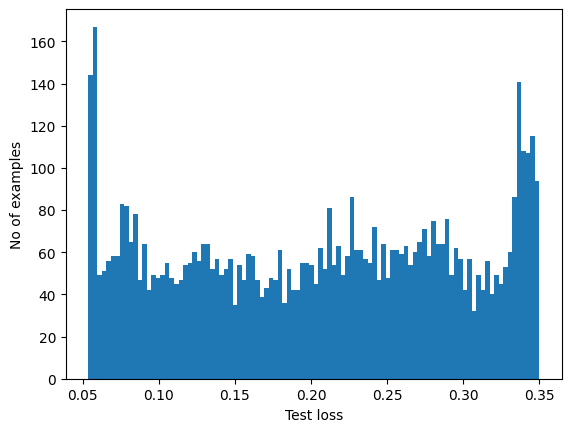

In [37]:
plt.hist(tmp, bins=100)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

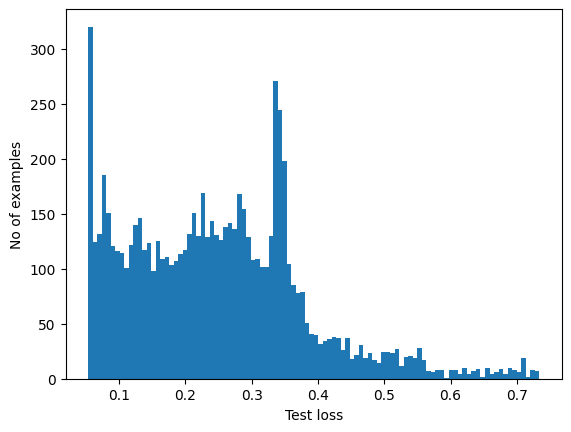

In [24]:
plt.hist(loss[None, :], bins=100)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [43]:
preds = predict(autoencoder, test_df, 0.38)

In [44]:
list(preds).count(0),list(preds).count(1)

(6483, 906)

## 2nd try

In [56]:
for i in df_data.index:
  print(i)
  break

0


In [106]:
type_list = []
idx_list = []

type_tmp_2 = []
type_tmp_1 = []
type_tmp_5 = []
type_tmp_e = []

type_idx_2 = []
type_idx_1 = []
type_idx_5 = []
type_idx_e = []

for i in df_data.index:
  #print(row)
  row = df_data.loc[i,:]

  if row['type'] == 20:
    type_tmp_2.append(row)
    type_idx_2.append(i)
  elif row['type'] == 10:
    type_tmp_1.append(row)
    type_idx_1.append(i)
  elif row['type'] == 50:
    type_tmp_5.append(row)
    type_idx_5.append(i)
  else:
    type_tmp_e.append(row)
    type_idx_e.append(i)

idx_list.append(type_idx_2)
idx_list.append(type_idx_1)
idx_list.append(type_idx_5)
idx_list.append(type_idx_e)

type_list.append(type_tmp_2)
type_list.append(type_tmp_1)
type_list.append(type_tmp_5)
type_list.append(type_tmp_e)

In [107]:
df_list = []

for ls in type_list:
  df = pd.DataFrame(ls).drop(axis=1,columns=['type'])
  df_list.append(df)
  print(df.shape)

(1107, 6)
(1098, 6)
(918, 6)
(4266, 6)


In [108]:
models = []
preds = []

string_list = ['2','1','5','e']

for i in range(4): 
  with open('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/s_' + string_list[i] + '.pickle', 'rb') as f:
    scaler = pickle.load(f)
  
  scarer_df = scaler.transform(df_list[i])

  m = model(scarer_df.shape[1])
  m.load_weights('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/m_' + string_list[i] + '.h5')

  reconstructions = m.predict(scarer_df)
  loss = tf.keras.losses.mae(reconstructions, scarer_df)

  threshold = np.mean(loss) + np.std(loss)
  print("Threshold: ", threshold)

  pred = tf.math.less(loss, threshold)
  pred = np.where(pred,0,1)
  preds.append(pred)




35/35 [==============================] - 0s 1ms/step
Threshold:  0.29163836585155134
35/35 [==============================] - 0s 2ms/step
Threshold:  0.34922880003989565
29/29 [==============================] - 0s 2ms/step
Threshold:  1.9302059509768212
134/134 [==============================] - 0s 1ms/step
Threshold:  0.29278789979214115


In [109]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/Data/answer_sample.csv')

for p, idx in zip(preds, idx_list) :
  submit.loc[idx,'label'] = p



In [110]:
list(submit['label']).count(0), list(submit['label']).count(1)

(6174, 1215)

In [111]:
submit.to_csv('./sub2023040720.csv', index=False)

# Submission


In [97]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/Data/answer_sample.csv')

In [98]:
submit

,type,label
0,0,-1
1,0,-1
2,0,-1
3,0,-1
4,0,-1
...,...,...
7384,7,-1
7385,7,-1
7386,7,-1
7387,7,-1


In [75]:
list(submit['type']).count(2)

1098

In [46]:
submit['label'] = preds
submit.head()

,type,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [47]:
submit.to_csv('./sub2023040714.csv', index=False)